# Figure 4
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [1]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, cm
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from scipy import stats
import cartopy as cart

Data locations

In [2]:
loc_shp = "../Data/CountryShapefile/"
loc_pop = "../Data/Population/"
loc_panel = "../Data/Panel/"
loc_damages_processed = "../Data/Damages/Processed/"

Shapefile

In [3]:
shp = gp.read_file(loc_shp)
iso_shp = shp.ISO3.values

#### Analysis/plotting

Settings

In [4]:
accounting = "territorial"
funcname = "BHMSR"
y1 = 1990
y2 = 2014
fname_str = funcname+"_"+accounting+"_shares"+str(y1)+"-"+str(y2)+"_"+str(y2)

Get data on damage caused and suffered by income quintile

In [5]:
attr_damage_quintiles = xr.open_dataset(loc_damages_processed+"attributable_damages_byincome_"+fname_str+"_v2.nc")

In [6]:
mn = attr_damage_quintiles.attr_damage_avg_mean.stack(x=("damaged_quintile","attr_quintile")) #attr_damage_sum_mean
sd = attr_damage_quintiles.attr_damage_avg_sd.stack(x=("damaged_quintile","attr_quintile"))

Get country income quintiles

In [7]:
panel = pd.read_csv(loc_panel+"Attribution_DamageFunction_Panel.csv")
iso_unique = np.array(list(sorted(set(panel["ISO"].values)))).astype(str)
panel_yrs = panel.loc[(panel["Year"]>=y1)&(panel["Year"]<=y2),:]
gpc = panel_yrs["GPC"].values
iso_panel = panel_yrs["ISO"].values
iso_continuous = [len(gpc[(~np.isnan(gpc)) & (iso_panel==iso)]) == len(np.arange(y1,y2+1,1)) for iso in iso_unique]
iso_uq_continuous = iso_unique[iso_continuous]

# slice panel data
obs_data = panel_yrs.loc[:,["Year","ISO","GPC","Temp","lnGPC","growth"]]
# calculate mean across years
obs_data_mean = obs_data.groupby("ISO").mean().reset_index().loc[:,["ISO","GPC"]]
obs_gpc = xr.DataArray(obs_data_mean.GPC.values,
                        coords=[obs_data_mean.ISO],dims=["iso"])
# calculate percentiles/quantiles
gpc_quintiles = xr.DataArray(np.array(pd.qcut(obs_gpc.values,[0,0.2,0.4,0.6,0.8,1.0],labels=False))+1.0,
                             coords=[obs_data_mean.ISO],dims=["iso"])

In [8]:
n_quintiles = np.zeros(5)
for q in np.arange(1,5+1,1):
    n_quintiles[q-1] = (gpc_quintiles==q).sum()

In [9]:
n_quintiles

array([33., 32., 33., 32., 33.])

Colorbar

In [10]:
cmin = 0.5
cmax = 5.5
nrange = 6
bounds = np.linspace(cmin,cmax,nrange)
cols = plt.get_cmap('Spectral_r')(np.linspace(0,1,len(bounds)+1))
cmap = colors.ListedColormap(cols[1:-1])
cmap.set_over(cols[-1])
cmap.set_under(cols[0])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds)-1)
cbar = plt.cm.ScalarMappable(norm=norm,cmap=cmap)

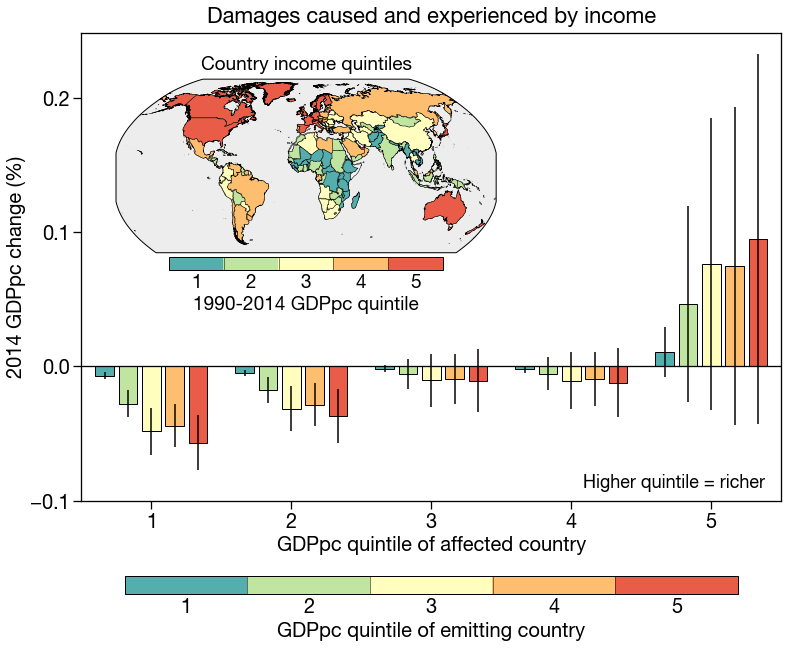

In [11]:
fig = plt.figure(figsize=(12,10))
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1
rcParams['xtick.major.size'] = 4
rcParams['xtick.major.width'] = 1
rcParams['ytick.major.size'] = 4
rcParams['ytick.major.width'] = 1

tfs = 22


gs2 = gridspec.GridSpec(1,1)
gs2.update(left=0.15,right=0.96,top=0.9,bottom=0.25,wspace=0.03,hspace=0.2)
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

ax = plt.subplot(gs2[0,0])

x = [1,2,3,4,5,\
     7,8,9,10,11,\
     13,14,15,16,17,\
     19,20,21,22,23,\
     25,26,27,28,29]
xdim = [1,2,3,4,5,\
     1,2,3,4,5,\
     1,2,3,4,5,\
     1,2,3,4,5,\
     1,2,3,4,5]
xtks = [3,9,15,21,27]
vlines = [6,12,18,24]

cols = [cbar.to_rgba(x) for x in xdim]

plt.bar(x=x,height=mn,yerr=sd,edgecolor="black",
       color=cols,
        error_kw={"ecolor":"black"})
        #capsize, capthick
    
plt.xticks(ticks=xtks,labels=["1","2","3","4","5"])
plt.xlabel("GDPpc quintile of affected country")
plt.ylabel("2014 GDPpc change (%)")
plt.xlim([0,30])
plt.title("Damages caused and experienced by income",fontsize=tfs,
         pad=10)

plt.yticks([-0.1,0,0.1,0.2])

plt.axhline(y=0,color="black",linewidth=1.3,linestyle="-")
#for v in vlines:
#    plt.axvline(x=v,color="gray",linewidth=1.3,linestyle="-")

plt.text(21.5,-0.09,"Higher quintile = richer",
        fontsize=18)

## n of countries
#for x in np.arange(1,5+1,1):
#    plt.text(x-0.3,0.005,int(n_quintiles[x-1]),
#            fontsize=14)


## colorbar
l = 0.2
b = 0.12
w = 0.71
h = 0.026
cbar_ax = fig.add_axes([l,b,w,h])
rcParams["axes.linewidth"] = 1
cb = fig.colorbar(cbar,cax=cbar_ax,orientation="horizontal",
                  drawedges=True,extend="neither",
                 ticks=[1,2,3,4,5])
cb.set_label("GDPpc quintile of emitting country",
            fontsize=20,labelpad=5)
cbar_ax.tick_params(labelsize=20,direction="in",
                    width=0,size=0)



## inset map
ax = fig.add_axes([0.19,0.54,0.44,0.32],projection=ccrs.Robinson())
ax.set_extent([-180,180,-63,90],crs=ccrs.PlateCarree())
plt.setp(ax.spines.values(), linewidth=0.3)
ax.coastlines(linewidth=0.5)
ax.add_feature(cart.feature.OCEAN, edgecolor="white",facecolor=[0.93,0.93,0.93])

for i in gpc_quintiles.iso.values:
    if i in iso_shp:
        val = gpc_quintiles.loc[i].values
        if ~np.isnan(val):
                ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=cbar.to_rgba(val),edgecolor="black",linewidth=0.5)
        else:
            ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                                  facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)
    else:
        ax.add_geometries(shp.loc[shp["ISO3"].values==i,"geometry"],ccrs.PlateCarree(),
                              facecolor=[0.95,0.95,0.95],edgecolor="black",linewidth=0.5)

plt.title("Country income quintiles",fontsize=19,
         pad=10)

cb = plt.colorbar(cbar,orientation='horizontal',
                  drawedges=True,extend="neither",
                  shrink=0.72,pad=0.02,
                  ticks=[1,2,3,4,5],aspect=21)
cb.ax.tick_params(direction="in",width=0,size=0,labelsize=19)
cb.set_label(str(y1)+"-"+str(y2)+" GDPpc quintile",fontsize=19)


#plt.figtext(0.14,0.82,r'$\bf{a}$',fontsize=26)
#plt.figtext(0.14,0.51,r'$\bf{b}$',fontsize=26)

plt.savefig("../Figures/Fig4.pdf")

plt.show()